In [104]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import accuracy_score,r2_score

In [239]:
df = pd.read_csv('DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [241]:
# uncomment the following line for generating daily data
df2 = df[df['Datetime'].str.contains("00:00:00")]

In [242]:
df2

,Datetime,DOM_MW
23,2006-01-01 00:00:00,9649.0
47,2005-12-31 00:00:00,9945.0
71,2005-12-30 00:00:00,9521.0
95,2005-12-29 00:00:00,9045.0
119,2005-12-28 00:00:00,10493.0
...,...,...
116092,2018-01-06 00:00:00,18620.0
116116,2018-01-05 00:00:00,17719.0
116140,2018-01-04 00:00:00,14660.0
116164,2018-01-03 00:00:00,17499.0


In [106]:
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [107]:
df.Datetime = pd.to_datetime(df.Datetime,format="%Y-%m-%d %H:%M:%S")
df.index= df.Datetime
df.drop('Datetime',inplace=True,axis=1)

In [108]:
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [109]:
df.isna().sum()

DOM_MW    0
dtype: int64

<AxesSubplot:xlabel='Datetime'>

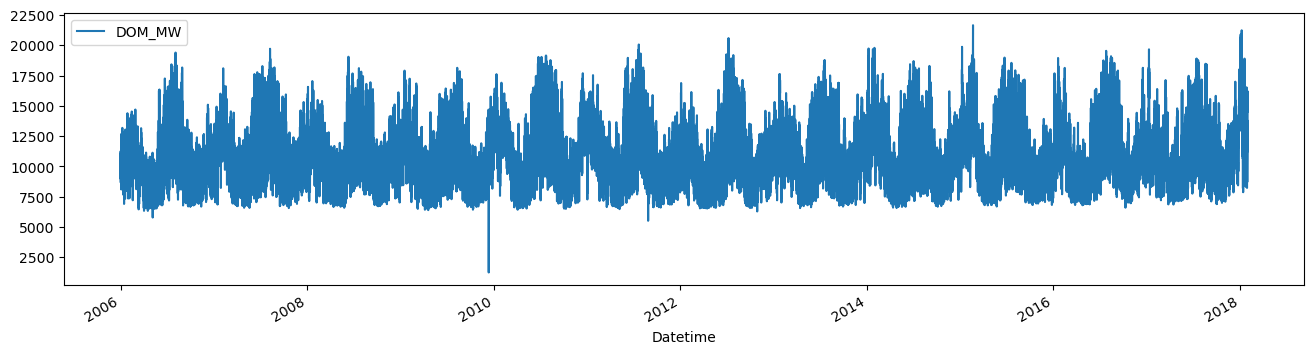

In [110]:
a = '2005-12-31'#@param {type:"date"}
b = '2018-01-31' #@param {type:"date"}

a = a+" 00:00:00"
b = b+" 00:00:00"


df.loc[a:b].plot(figsize=(16,4,),legend=True)

In [111]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler= MinMaxScaler()
df.DOM_MW = scaler.fit_transform(df.DOM_MW.values.reshape(-1,1))

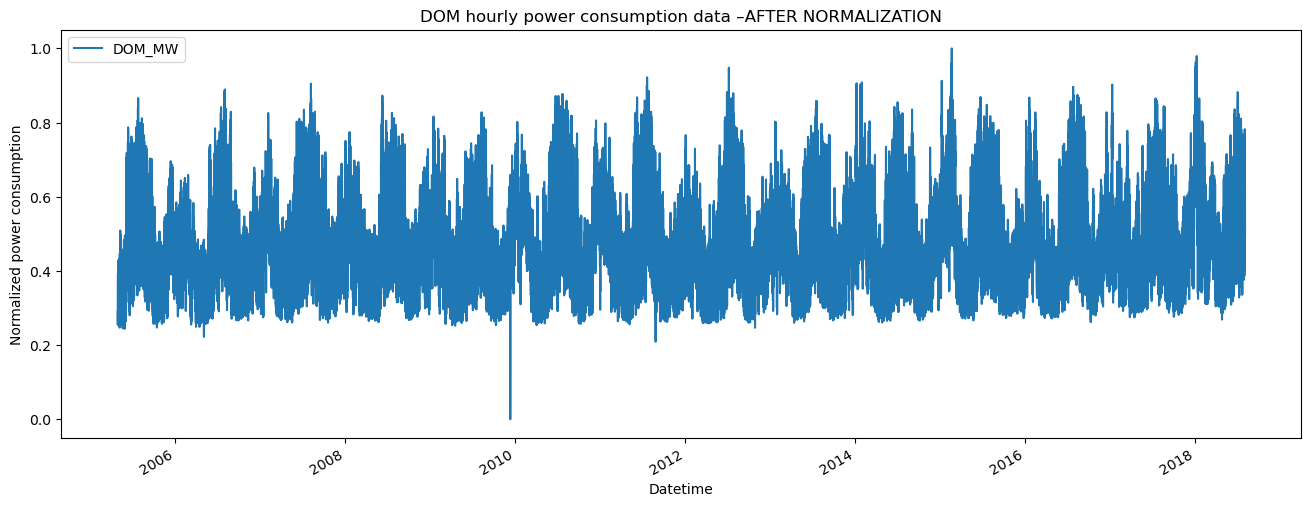

In [112]:
df.plot(figsize=(16,6))
plt.title('DOM hourly power consumption data –AFTER NORMALIZATION')
plt.ylabel('Normalized power consumption')
plt.show()

In [113]:
df

,DOM_MW
Datetime,
2005-12-31 01:00:00,0.398863
2005-12-31 02:00:00,0.383224
2005-12-31 03:00:00,0.379841
2005-12-31 04:00:00,0.381851
2005-12-31 05:00:00,0.386263
...,...
2018-01-01 20:00:00,0.841504
2018-01-01 21:00:00,0.848809
2018-01-01 22:00:00,0.836062


In [114]:
df.iloc[1,0]

0.38322384547504657

In [131]:
from sklearn.model_selection import train_test_split
def load_data(stock,seq_len):
    X_train = []
    y_train = []
    for i in range (len(stock)-seq_len):
        X_train.append(stock.iloc[i:i+seq_len,0])
        y_train.append(stock.iloc[i+seq_len,0])
    x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.1)
    x_train= np.array(x_train)
    x_test= np.array(x_test)
    y_train= np.array(y_train)
    y_test= np.array(y_test)
    x_train= np.reshape(x_train,(x_train.shape[0],seq_len,1))
    x_test= np.reshape(x_test,(x_test.shape[0],seq_len,1))
    
    return x_train,y_train,x_test,y_test

In [132]:
seq_len = 20 #choose sequence length
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [133]:
X_train.shape

(104552, 20, 1)

In [134]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (104552, 20, 1)
y_train.shape =  (104552,)
X_test.shape =  (11617, 20, 1)
y_test.shape =  (11617,)


In [135]:
batch_size  = 256
buffer_size = 1000


train_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()


test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat()


2023-05-10 16:22:05.953926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [138]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=8,input_shape= X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [141]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
rnn_model.compile(optimizer = 'adam', loss = 'mae')

In [155]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [142]:
rnn_model.fit(train_data,epochs = EPOCHS,steps_per_epoch = EVALUATION_INTERVAL,validation_data = test_data,validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 5s 13ms/step - loss: 0.1196 - val_loss: 0.0668
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0614 - val_loss: 0.0559
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0491 - val_loss: 0.0404
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0308 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0233 - val_loss: 0.0219
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0204 - val_loss: 0.0194
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0144 - val_lo

<AxesSubplot:>

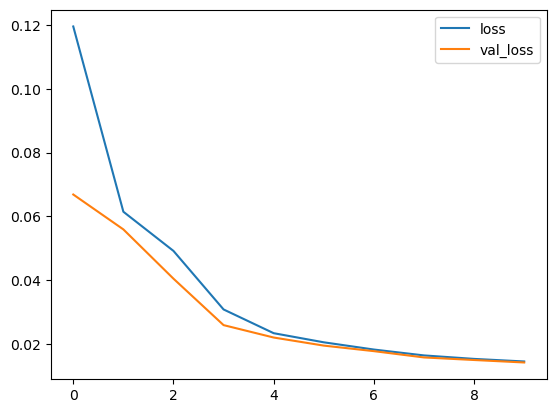

In [144]:
pd.DataFrame(rnn_model.history.history[""]).plot()

In [145]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)

364/364 [==============================] - 1s 2ms/step


In [146]:
print("R2 Score of RNN model ="+"{:.4f}".format(rnn_score));


R2 Score of RNN model =0.9653


In [147]:
a =0 
b = 120000

def plot_prediction(test,predicted,title):
    plt.figure(figsize=(16,4))
    plt.plot(test[a:b],color='blue',label="Normalized power consumption")
    plt.plot(predicted[a:b],color='orange',label = 'Predicted power consumption')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption')
    plt.legend()
    plt.show()

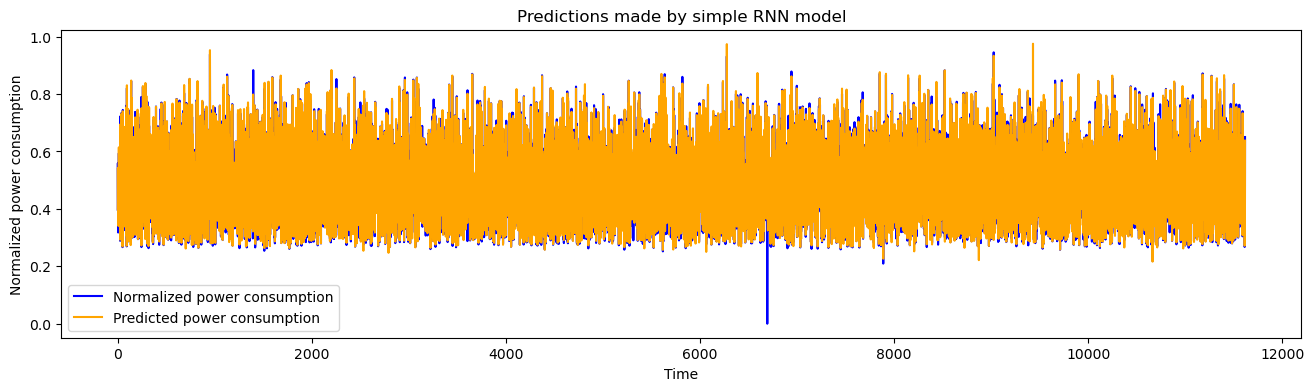

In [149]:
plot_prediction(y_test, rnn_predictions,"Predictions made by simple RNN model")


In [158]:
x= X_test[-1:]
rnn_prediction = rnn_model.predict(x)

1/1 [==============================] - 0s 32ms/step


In [160]:
rnn_prediction

array([[0.6376482]], dtype=float32)

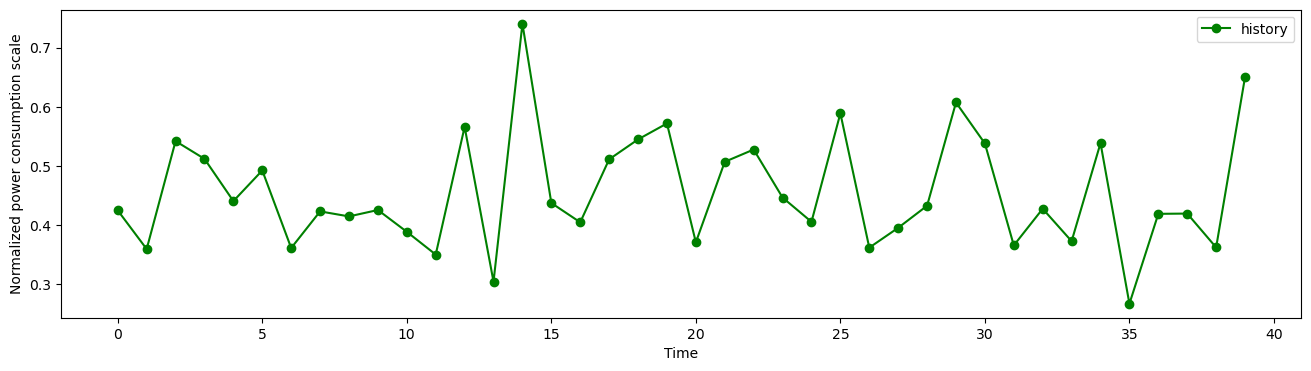

In [198]:
hist = list(y_test[-40:])
plt.figure(figsize=(16,4))
plotting_values = list(hist)+list(rnn_prediction)
# plt.plot(plotting_values, color = 'orange',label = 'forecasted value',marker="x")
plt.plot(y_test[-40:],label = 'history', color = 'green',marker="o")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()

plt.show()

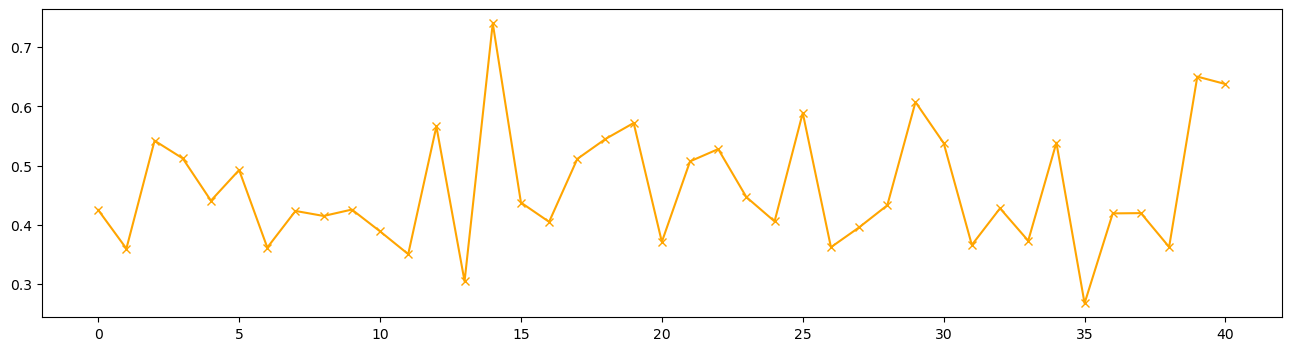

In [200]:
plt.figure(figsize=(16,4))
plt.plot(plotting_values, color = 'orange',label = 'forecasted value',marker="x")



In [161]:
y_test[-40:]

array([0.4248946 , 0.3596431 , 0.54201392, 0.51206001, 0.44068046,
       0.49245024, 0.36140798, 0.42327679, 0.41479557, 0.42562996,
       0.38881263, 0.35032846, 0.56608491, 0.30449064, 0.7403667 ,
       0.43744485, 0.40484361, 0.51122659, 0.54490636, 0.57186979,
       0.37101677, 0.50705952, 0.52779684, 0.44666144, 0.405628  ,
       0.58893029, 0.36199627, 0.39552897, 0.43283655, 0.60726542,
       0.53799392, 0.36582018, 0.42773801, 0.37292872, 0.53858221,
       0.26728111, 0.41915874, 0.41959996, 0.36238847, 0.65025983])

In [209]:
def make_data(X,rnn_predictions1):
    val = list(X[0][1:])+list(rnn_predictions1)
    X_new = []
    X_new.append(list(val))
    X_new = np.array(X_new)
    return X_new

In [234]:
rnn_predictions1 = rnn_model.predict(X)
forecast = list()
X = X_test[-1:]
for i in range(25):
    X= make_data(X,rnn_predictions1)
    rnn_predictions1 = rnn_model.predict(X)
    forecast+=list(rnn_predictions1)

1/1 [==============================] - 0s 27ms/step


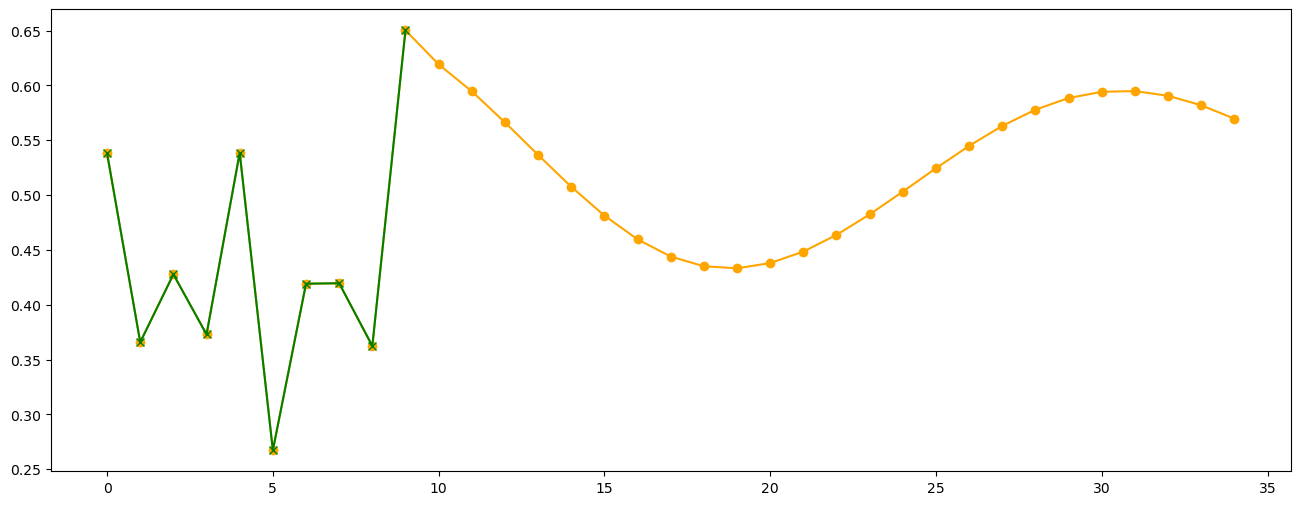

In [237]:
hist = list(y_test[-10:]) + list(forecast)
plt.figure(figsize=(16,6))
plt.plot(hist,color='orange',marker='o')
plt.plot(y_test[-10:],color='green',marker='x')

In [232]:
hist

[0.42489459750955977,
 0.3596431022649279,
 0.5420139229336209,
 0.5120600058829297,
 0.4406804588685165,
 0.49245024021962935,
 0.36140798117462497,
 0.42327679184233746,
 0.4147955681929601,
 0.4256299637219335,
 0.38881262868908717,
 0.3503284635748603,
 0.566084910285322,
 0.30449063633689577,
 0.7403667026179037,
 0.437444847534072,
 0.4048436121188352,
 0.5112265908422394,
 0.5449063633689577,
 0.5718697911559957,
 0.37101676634964215,
 0.5070595156387881,
 0.5277968428277282,
 0.4466614373958231,
 0.4056280027453672,
 0.588930287283067,
 0.36199627414452396,
 0.3955289734287675,
 0.43283655260319637,
 0.6072654181782527,
 0.5379939209726444,
 0.36582017844886755,
 0.4277380135307383,
 0.3729287185018139,
 0.5385822139425434,
 0.2672811059907834,
 0.4191587410530444,
 0.4195999607804687,
 0.36238846945778996,
 0.6502598293950387,
 array([], dtype=float64)]

In [233]:
list(forecast)

[array([], dtype=float64)]

In [214]:
X == X[1:]

array([], shape=(0, 20, 1), dtype=bool)